In [1]:
import nltk
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> stopwords
      Unzipping corpora/stopwords.zip.

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> gutenberg
      Unzipping corpora/gutenberg.zip.

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import gutenberg, stopwords
from collections import Counter


Supervised NLP requires a pre-labelled dataset for training and testing, and is generally interested in categorizing text in various ways. In this case, we are going to try to predict whether a sentence comes from _Alice in Wonderland_ by Lewis Carroll or _Persuasion_ by Jane Austen. We can use any of the supervised models we've covered previously, as long as they allow categorical outcomes. In this case, we'll try Random Forests, SVM, and KNN.

Our feature-generation approach will be something called _BoW_, or _Bag of Words_. BoW is quite simple: For each sentence, we count how many times each word appears. We will then use those counts as features.  

In [3]:
# Utility function for standard text cleaning.
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text
    
# Load and clean the data.
persuasion = gutenberg.raw('austen-persuasion.txt')
alice = gutenberg.raw('carroll-alice.txt')

# The Chapter indicator is idiosyncratic
persuasion = re.sub(r'Chapter \d+', '', persuasion)
alice = re.sub(r'CHAPTER .*', '', alice)
    
alice = text_cleaner(alice)
persuasion = text_cleaner(persuasion)

In [4]:
# Parse the cleaned novels. This can take a bit.
nlp = spacy.load('en')
alice_doc = nlp(alice)
persuasion_doc = nlp(persuasion)

In [51]:
# Group into sentences.
alice_sents = [[sent, "Carroll"] for sent in alice_doc.sents]
persuasion_sents = [[sent, "Austen"] for sent in persuasion_doc.sents]

# Combine the sentences from the two novels into one data frame.
sentences = pd.DataFrame(alice_sents + persuasion_sents)
sentences.head()

,0,1
0,"(Alice, was, beginning, to, get, very, tired, ...",Carroll
1,"(So, she, was, considering, in, her, own, mind...",Carroll
2,"(There, was, nothing, so, VERY, remarkable, in...",Carroll
3,"(Oh, dear, !)",Carroll
4,"(I, shall, be, late, !, ')",Carroll


Time to bag some words!  Since spaCy has already tokenized and labelled our data, we can move directly to recording how often various words occur.  We will exclude stopwords and punctuation.  In addition, in an attempt to keep our feature space from exploding, we will work with lemmas (root words) rather than the raw text terms, and we'll only use the 2000 most common words for each text.

In [52]:
# Utility function to create a list of the 2000 most common words.
def bag_of_words(text):
    
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(2000)]
    

# Creates a data frame with features for each word in our common word set.
# Each value is the count of the times the word appears in each sentence.
def bow_features(sentences, common_words):
    
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=common_words)
    df['text_sentence'] = sentences[0]
    df['text_source'] = sentences[1]
    df.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['text_sentence']):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        
        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 500 == 0:
            print("Processing row {}".format(i))
            
    return df

# Set up the bags.
alicewords = bag_of_words(alice_doc)
persuasionwords = bag_of_words(persuasion_doc)

# Combine bags to create a set of unique words.
common_words = set(alicewords + persuasionwords)

In [53]:
# Create our data frame with features. This can take a while to run.
word_counts = bow_features(sentences, common_words)
word_counts.head()

Processing row 0
Processing row 500
Processing row 1000
Processing row 1500
Processing row 2000
Processing row 2500
Processing row 3000
Processing row 3500
Processing row 4000
Processing row 4500
Processing row 5000


,circle,nation,interchange,wentworth,desert,stranger,ma,lark,leant,retire,...,particular,buttercup,quiet,root,favourite,sneeze,adjourn,habit,text_sentence,text_source
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Alice, was, beginning, to, get, very, tired, ...",Carroll
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(So, she, was, considering, in, her, own, mind...",Carroll
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(There, was, nothing, so, VERY, remarkable, in...",Carroll
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Oh, dear, !)",Carroll
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(I, shall, be, late, !, ')",Carroll


## Trying out BoW

Now let's give the bag of words features a whirl by trying a random forest.

In [8]:
from sklearn import ensemble
from sklearn.model_selection import train_test_split

rfc = ensemble.RandomForestClassifier()
Y = word_counts['text_source']
X = np.array(word_counts.drop(['text_sentence','text_source'], 1))

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.4,
                                                    random_state=0)
train = rfc.fit(X_train, y_train)

print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

Training set score: 0.987147335423

Test set score: 0.887218045113


Holy overfitting, Batman! Overfitting is a known problem when using bag of words, since it basically involves throwing a massive number of features at a model – some of those features (in this case, word frequencies) will capture noise in the training set. Since overfitting is also a known problem with Random Forests, the divergence between training score and test score is expected.


## BoW with Logistic Regression

Let's try a technique with some protection against overfitting due to extraneous features – logistic regression with ridge regularization (from ridge regression, also called L2 regularization).

In [9]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
train = lr.fit(X_train, y_train)
print(X_train.shape, y_train.shape)
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

(3190, 3062) (3190,)
Training set score: 0.957993730408

Test set score: 0.915883458647


Logistic regression performs a bit better than the random forest.  

# BoW with Gradient Boosting

And finally, let's see what gradient boosting can do:

In [10]:
clf = ensemble.GradientBoostingClassifier()
train = clf.fit(X_train, y_train)

print('Training set score:', clf.score(X_train, y_train))
print('\nTest set score:', clf.score(X_test, y_test))

Training set score: 0.886833855799

Test set score: 0.873590225564


Looks like logistic regression is the winner, but there's room for improvement.

# Same model, new inputs

What if we feed the model a different novel by Jane Austen, like _Emma_?  Will it be able to distinguish Austen from Carroll with the same level of accuracy if we insert a different sample of Austen's writing?

First, we need to process _Emma_ the same way we processed the other data, and combine it with the Alice data:

In [11]:
# Clean the Emma data.
emma = gutenberg.raw('austen-emma.txt')
emma = re.sub(r'VOLUME \w+', '', emma)
emma = re.sub(r'CHAPTER \w+', '', emma)
emma = text_cleaner(emma)
print(emma[:100])

Emma Woodhouse, handsome, clever, and rich, with a comfortable home and happy disposition, seemed to


In [12]:
# Parse our cleaned data.
emma_doc = nlp(emma)

In [13]:
# Group into sentences.
persuasion_sents = [[sent, "Austen"] for sent in persuasion_doc.sents]
emma_sents = [[sent, "Austen"] for sent in emma_doc.sents]

# Emma is quite long, let's cut it down to the same length as Alice.
emma_sents = emma_sents[0:len(alice_sents)]

In [14]:
# Build a new Bag of Words data frame for Emma word counts.
# We'll use the same common words from Alice and Persuasion.
emma_sentences = pd.DataFrame(emma_sents)
emma_bow = bow_features(emma_sentences, common_words)

print('done')

Processing row 0
Processing row 500
Processing row 1000
Processing row 1500
done


In [15]:
# Now we can model it!
# Let's use logistic regression again.

# Combine the Emma sentence data with the Alice data from the test set.
X_Emma_test = np.concatenate((
    X_train[y_train[y_train=='Carroll'].index],
    emma_bow.drop(['text_sentence','text_source'], 1)
), axis=0)
y_Emma_test = pd.concat([y_train[y_train=='Carroll'],
                         pd.Series(['Austen'] * emma_bow.shape[0])])

# Model.
print('\nTest set score:', lr.score(X_Emma_test, y_Emma_test))
lr_Emma_predicted = lr.predict(X_Emma_test)
pd.crosstab(y_Emma_test, lr_Emma_predicted)


Test set score: 0.697613721104


col_0,Austen,Carroll
row_0,,
Austen,1564,105
Carroll,706,307


Well look at that!  NLP approaches are generally effective on the same type of material as they were trained on. It looks like this model is actually able to differentiate multiple works by Austen from Alice in Wonderland.  Now the question is whether the model is very good at identifying Austen, or very good at identifying Alice in Wonderland, or both...

# Challenge 0:

Recall that the logistic regression model's best performance on the test set was 93%.  See what you can do to improve performance.  Suggested avenues of investigation include: Other modeling techniques (SVM?), making more features that take advantage of the spaCy information (include grammar, phrases, POS, etc), making sentence-level features (number of words, amount of punctuation), or including contextual information (length of previous and next sentences, words repeated from one sentence to the next, etc), and anything else your heart desires.  Make sure to design your models on the test set, or use cross_validation with multiple folds, and see if you can get accuracy above 90%.  

### Trying it with SVM

In [16]:
from sklearn.svm import SVC
svm = SVC()

svm.fit(X_train, y_train)

print('Training set score:', svm.score(X_train, y_train))
print('\nTest set score:', svm.score(X_test, y_test))

Training set score: 0.682445141066

Test set score: 0.691729323308


In [18]:
from sklearn.grid_search import GridSearchCV

#param_test1 = {'C':[0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 2, 2.5, 5, 10]}
param_test1 = {'C':[8,9,10,11,12,13,14,15,20,30,40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180]}

gsearch1 = GridSearchCV(estimator = SVC(), param_grid = param_test1, scoring='accuracy', n_jobs=4, iid=False, cv=5)
gsearch1.fit(X_train, y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.77054, std: 0.01065, params: {'C': 8},
  mean: 0.77900, std: 0.00885, params: {'C': 9},
  mean: 0.79373, std: 0.00634, params: {'C': 10},
  mean: 0.80031, std: 0.00792, params: {'C': 11},
  mean: 0.80344, std: 0.00820, params: {'C': 12},
  mean: 0.80721, std: 0.00745, params: {'C': 13},
  mean: 0.81034, std: 0.00767, params: {'C': 14},
  mean: 0.81285, std: 0.00746, params: {'C': 15},
  mean: 0.83135, std: 0.00771, params: {'C': 20},
  mean: 0.84891, std: 0.00787, params: {'C': 30},
  mean: 0.85644, std: 0.01036, params: {'C': 40},
  mean: 0.86177, std: 0.00867, params: {'C': 50},
  mean: 0.86490, std: 0.01014, params: {'C': 60},
  mean: 0.86866, std: 0.01080, params: {'C': 70},
  mean: 0.87211, std: 0.01135, params: {'C': 80},
  mean: 0.87587, std: 0.01310, params: {'C': 90},
  mean: 0.87744, std: 0.01401, params: {'C': 100},
  mean: 0.87838, std: 0.01401, params: {'C': 110},
  mean: 0.87932, std: 0.01216, params: {'C': 120},
  mean: 0.88120, std: 0.01225, params: {'C': 130}

### Trying with punctuation

In [72]:
# Utility function to create a list of the 2000 most common words.
def bag_of_word_pun(text):
    
    # Filter out stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_stop]
                
    
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(2000)]
    

# Creates a data frame with features for each word in our common word set.
# Each value is the count of the times the word appears in each sentence.
def bow_features_pun(sentences, common_words):
    
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=common_words)
    df['text_sentence'] = sentences[0]
    df['text_source'] = sentences[1]
    df.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['text_sentence']):
        
        # Convert the sentence to lemmas, then filter out
        # stop words, and uncommon words.
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_stop
                     and token.lemma_ in common_words
                 )]
        
        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 500 == 0:
            print("Processing row {}".format(i))
            
    return df

# Set up the bags.
alicewords = bag_of_word_pun(alice_doc)
persuasionwords = bag_of_word_pun(persuasion_doc)

# Combine bags to create a set of unique words.
common_words = set(alicewords + persuasionwords)

In [73]:
word_counts = bow_features_pun(sentences, common_words)
word_counts.head()

Processing row 0
Processing row 500
Processing row 1000
Processing row 1500
Processing row 2000
Processing row 2500
Processing row 3000


,circle,nation,interchange,wentworth,desert,stranger,ma,lark,leant,retire,...,particular,buttercup,quiet,root,favourite,sneeze,adjourn,habit,text_sentence,text_source
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Alice, was, beginning, to, get, very, tired, ...",Carroll
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(So, she, was, considering, in, her, own, mind...",Carroll
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(There, was, nothing, so, VERY, remarkable, in...",Carroll
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Oh, dear, !)",Carroll
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(I, shall, be, late, !, ')",Carroll


In [74]:
Y = word_counts['text_source']
X = np.array(word_counts.drop(['text_sentence','text_source'], 1))

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.4,
                                                    random_state=0)

### Logistic Regression

/home/ec2-user/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


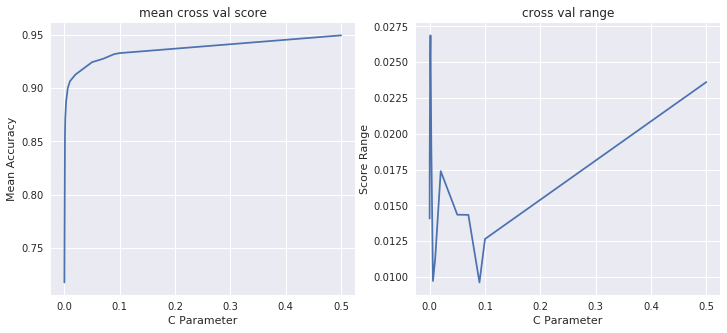

In [23]:
from sklearn.model_selection import cross_val_score

# tune l2 regularization
param_tune = []
for i in [0.000001, 0.00001, 0.0001, 0.001, 0.0015, 0.003, 0.006, 0.01, 0.02, 0.05, 0.07, 0.09, 0.1, 0.5]:
#for i in [0.001, 0.0015, 0.002, 0.0025, 0.003, 0.0035, 0.004, 0.0045, 0.005, 0.0055, 0.006, 0.01]:
    ridge = LogisticRegression(penalty='l2', C=i)
    ridge.fit(X_train, y_train)
    score = cross_val_score(ridge, X_train, y_train, cv=5)
    mean_score = score.mean()
    score_range = score.max() - score.min()
    param_tune.append([i, mean_score, score_range])

param_tune = pd.DataFrame(param_tune)
param_tune.columns = ['parameter', 'mean_score', 'score_range']

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(param_tune.parameter, param_tune.mean_score)
plt.title('mean cross val score')
plt.xlabel('C Parameter')
plt.ylabel('Mean Accuracy')

plt.subplot(1, 2, 2)
plt.plot(param_tune.parameter, param_tune.score_range)
plt.title('cross val range')
plt.xlabel('C Parameter')
plt.ylabel('Score Range')

plt.show()

In [24]:
param_tune

,parameter,mean_score,score_range
0,0.000001,0.717865,0.014085
1,0.000010,0.719121,0.014085
2,0.000100,0.736673,0.018064
3,0.001000,0.855790,0.025535
4,0.001500,0.870527,0.026875
5,0.003000,0.886829,0.019177
6,0.006000,0.899683,0.009719
7,0.010000,0.906265,0.011269
8,0.020000,0.912533,0.017394
9,0.050000,0.924131,0.014350


In [57]:
lr = LogisticRegression(C=.5)
train = lr.fit(X_train, y_train)
print(X_train.shape, y_train.shape)
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

(3190, 3068) (3190,)
Training set score: 0.970532915361

Test set score: 0.955357142857


In [58]:
cross_val_score(lr, X_train, y_train, cv=10)

array([ 0.95625   ,  0.953125  ,  0.959375  ,  0.94984326,  0.94984326,
        0.96238245,  0.95297806,  0.93396226,  0.93396226,  0.94968553])

# Challenge 1:
Find out whether your new model is good at identifying Alice in Wonderland vs any other work, Persuasion vs any other work, or Austen vs any other work.  This will involve pulling a new book from the Project Gutenberg corpus (print(gutenberg.fileids()) for a list) and processing it.

Record your work for each challenge in a notebook and submit it below.

In [28]:
print(gutenberg.fileids())

['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']


### Hamlet vs Alice 

In [75]:
# Clean the Hamlet data.
hamlet = gutenberg.raw('shakespeare-hamlet.txt')
hamlet = re.sub(r'Actus \w+.', '', hamlet)
hamlet = re.sub(r'Scoena \w+.', '', hamlet)
hamlet = text_cleaner(hamlet)
print(hamlet[:100])

Enter Barnardo and Francisco two Centinels. Barnardo. Who's there? Fran. Nay answer me: Stand & vnfo


In [76]:
# Parse our cleaned data.
hamlet_doc = nlp(hamlet)

In [77]:
# Group into sentences.
hamlet_sents = [[sent, "Shakespeare"] for sent in hamlet_doc.sents]

In [78]:
#compare lengths
print(len(alice_sents))
print(len(hamlet_sents))

1669
3036


In [79]:
# Make hamlet the same length as alice.
hamlet_sents = hamlet_sents[0:len(alice_sents)]

In [80]:
hamlet_sentences = pd.DataFrame(hamlet_sents)

In [81]:
hamlet_bow = bow_features_pun(hamlet_sentences, common_words)

print('done')

Processing row 0
Processing row 500
Processing row 1000
Processing row 1500
done


In [87]:
X_hamlet_test = np.concatenate((
    X_train[y_train[y_train=='Carroll'].index],
    hamlet_bow.drop(['text_sentence','text_source'], 1)
), axis=0)
y_hamlet_test = pd.concat([y_train[y_train=='Carroll'],
                         pd.Series(['Shakespeare'] * hamlet_bow.shape[0])])

# Model.
train = lr.fit(X_train, y_train)
print('\nTest set score:', lr.score(X_hamlet_test, y_hamlet_test))
lr_hamlet_predicted = lr.predict(X_hamlet_test)
pd.crosstab(y_hamlet_test, lr_hamlet_predicted)


Test set score: 0.792374480936


col_0,Carroll,Shakespeare
row_0,,
Carroll,465,515
Shakespeare,35,1634


### The model performed poorly on the Hamlet data with original model settings, below I build and train based on hamlet and alice common words and tune the model. 

In [65]:
#sentences = pd.DataFrame(alice_sents + hamlet_sents)
#sentences.head()

,0,1
0,"(Alice, was, beginning, to, get, very, tired, ...",Carroll
1,"(So, she, was, considering, in, her, own, mind...",Carroll
2,"(There, was, nothing, so, VERY, remarkable, in...",Carroll
3,"(Oh, dear, !)",Carroll
4,"(I, shall, be, late, !, ')",Carroll


In [66]:
# Utility function to create a list of the 2000 most common words.
def bag_of_word_pun(text):
    
    # Filter out stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_stop]
                
    
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(2000)]
    

# Creates a data frame with features for each word in our common word set.
# Each value is the count of the times the word appears in each sentence.
def bow_features_pun(sentences, common_words):
    
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=common_words)
    df['text_sentence'] = sentences[0]
    df['text_source'] = sentences[1]
    df.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['text_sentence']):
        
        # Convert the sentence to lemmas, then filter out
        # stop words, and uncommon words.
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_stop
                     and token.lemma_ in common_words
                 )]
        
        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 500 == 0:
            print("Processing row {}".format(i))
            
    return df

# Set up the bags.
alicewords = bag_of_word_pun(alice_doc)
hamletwords = bag_of_word_pun(hamlet_doc)

# Combine bags to create a set of unique words.
common_words = set(alicewords + hamletwords)

In [67]:
# Create our data frame with features. This can take a while to run.
word_counts = bow_features(sentences, common_words)
word_counts.head()

Processing row 0
Processing row 500
Processing row 1000
Processing row 1500
Processing row 2000
Processing row 2500
Processing row 3000


,goodnight,circle,nation,personall,ma,lark,diet,leant,retire,maiesty,...,quiet,affaire,root,maiesticall,favourite,sneeze,adjourn,priuy,text_sentence,text_source
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Alice, was, beginning, to, get, very, tired, ...",Carroll
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(So, she, was, considering, in, her, own, mind...",Carroll
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(There, was, nothing, so, VERY, remarkable, in...",Carroll
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Oh, dear, !)",Carroll
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(I, shall, be, late, !, ')",Carroll


In [68]:
Y = word_counts['text_source']
X = np.array(word_counts.drop(['text_sentence','text_source'], 1))

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.4,
                                                    random_state=0)

/home/ec2-user/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


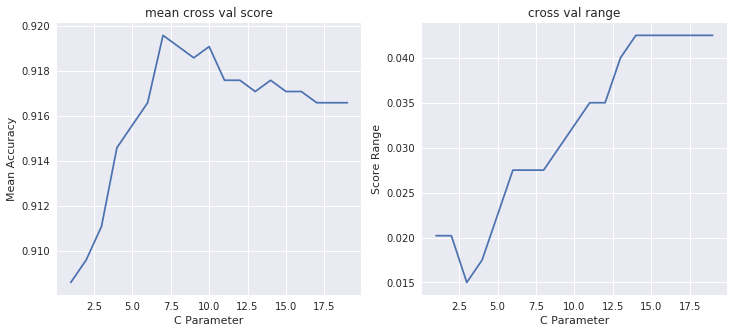

In [48]:
# tune l2 regularization
param_tune = []
#for i in [0.01, 0.02, 0.05, 0.07, 0.09, 0.1, 0.5, 0.7, 0.9, 1, 1.1, 1.2, 1.3, 1.5, 2, 3, 4, 5]:
for i in np.arange(1,20):
   
    ridge = LogisticRegression(penalty='l2', C=i)
    ridge.fit(X_train, y_train)
    score = cross_val_score(ridge, X_train, y_train, cv=5)
    mean_score = score.mean()
    score_range = score.max() - score.min()
    param_tune.append([i, mean_score, score_range])

param_tune = pd.DataFrame(param_tune)
param_tune.columns = ['parameter', 'mean_score', 'score_range']

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(param_tune.parameter, param_tune.mean_score)
plt.title('mean cross val score')
plt.xlabel('C Parameter')
plt.ylabel('Mean Accuracy')

plt.subplot(1, 2, 2)
plt.plot(param_tune.parameter, param_tune.score_range)
plt.title('cross val range')
plt.xlabel('C Parameter')
plt.ylabel('Score Range')

plt.show()

In [49]:
param_tune

,parameter,mean_score,score_range
0,1,0.908589,0.020206
1,2,0.909586,0.020200
2,3,0.911086,0.015000
3,4,0.914582,0.017500
4,5,0.915584,0.022500
5,6,0.916584,0.027500
6,7,0.919581,0.027500
7,8,0.919082,0.027500
8,9,0.918581,0.030000
9,10,0.919081,0.032500


In [50]:
lr = LogisticRegression(C=7)
train = lr.fit(X_train, y_train)
print(X_train.shape, y_train.shape)
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

(2002, 3359) (2002,)
Training set score: 0.988011988012

Test set score: 0.920658682635


### 92 percent accuracy on test set after tuning, but seems to overfit a bit.